In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import reciprocalspaceship as rs
import scipy.optimize as opt
import gemmi as gm
import pandas as pd
from tqdm import tqdm
import os
import sys
import diptest
from scipy.stats import norm, kurtosis, skew, differential_entropy
import matplotlib.mlab as mlab
import seaborn as sns
sns.set_context("notebook", font_scale=1.4)

In [2]:
from xtal_analysis.xtal_analysis_functions import *
from xtal_analysis.params import *

In [3]:
from skimage.restoration import denoise_tv_chambolle

#### Generate set of Q-weighted $\Delta$Fs

In [4]:
calc     = load_mtz('/Users/alisia/Desktop/scaling/Cl-rsEGFP2-SACLA/FC_dark.mtz')
off_fobs = load_mtz('/Users/alisia/Desktop/scaling/Cl-rsEGFP2-SACLA/neg5ps-400nm_fobs_unique1.mtz')
on_fobs  = load_mtz('/Users/alisia/Desktop/scaling/Cl-rsEGFP2-SACLA/100ps-400nm_fobs_unique1.mtz')

In [5]:
data       = pd.merge(calc, off_fobs, how='inner', right_index=True, left_index=True, suffixes=('_calc', '_off'))
data_all   = pd.merge(data, on_fobs, how='inner', right_index=True, left_index=True, suffixes=('_off', '_on')).dropna()
data_all   = res_cutoff(data_all, h_res, l_res)

fit_off, fit_c_off, fit_b_off, iso_off = scale_iso(data_all['FC_D'], data_all['F_off'], data_all['dHKL'])
fit_on,  fit_c_on,  fit_b_on,  iso_on  = scale_iso(data_all['FC_D'], data_all['F_on'], data_all['dHKL'])

In [6]:
fo_fo_diffs = iso_on - iso_off

In [7]:
qs        =  1/(2*data_all['dHKL'])

sig_off   =  (fit_c_off*np.exp(-fit_c_off*(qs**2)))* np.array(data_all['SIGF_off'])
sig_on    =  (fit_c_on*np.exp(-fit_c_on*(qs**2)))*np.array(data_all['SIGF_on'])

sig_diffs =  np.sqrt(sig_off**2 + sig_on**2)
ws_005    =  compute_weights(fo_fo_diffs, sig_diffs, 0.05)
ws_005_diffs = fo_fo_diffs * ws_005

#### Fix negative $\Delta$F compatibility

In [8]:
diff = res_cutoff(calc, h_res, l_res).copy(deep=True)

diff["w005"]  = ws_005_diffs
diff["w005"]  = diff["w005"].astype("SFAmplitude")

In [9]:
diff_pos = positive_Fs(diff, 'PHI_D', 'w005', 'new_og-Phis', 'new_og-Diffs')

#### Keep 3% of Q-weighted $\Delta$Fs for test dataset

In [10]:
test_set, fit_set = make_test_set(diff_pos, 0.03, 'new_og-Diffs', 'qw005')

#### Loop through values of $\lambda$ instead now

In [11]:
errors      = []
entropies   = []
diptests    = []
choose_test = np.load('test_flags-qw005.npy')

for l in np.linspace(1e-8, 0.1, 50):
    fit_map    = map_from_Fs('split-qw005.mtz', 'fit-set', 'new_og-Phis', 4)
    fit_TV_map, entropy, diptest = TV_filter(fit_map, l, 'fit')
    
    map_root  = 'fit_map_TV_{:.5f}'.format(l)
    map2mtz('{}.ccp4'.format(map_root), '{}.mtz'.format(map_root), h_res)
    
    Fs_fit_TV = load_mtz('{}.mtz'.format(map_root))
    Fs_fit_TV = res_cutoff(Fs_fit_TV, h_res, l_res)
    Fs_fit_TV = Fs_fit_TV[Fs_fit_TV.index.isin(diff_pos.index)]
    test_TV   = Fs_fit_TV['FWT'][choose_test]
    
    error     = np.sum(np.array(test_set) - np.array(test_TV))**2
    errors.append(error)
    diptests.append(diptest)
    entropies.append(entropy)


3686400it [00:30, 120301.63it/s]
3686400it [00:30, 119561.65it/s]
3686400it [00:30, 120862.50it/s]
3686400it [00:30, 119926.76it/s]
3686400it [00:30, 120115.53it/s]
3686400it [00:31, 116467.92it/s]
3686400it [00:30, 119397.34it/s]
3686400it [00:31, 117951.63it/s]
3686400it [00:31, 118004.04it/s]
3686400it [00:31, 117893.40it/s]
3686400it [00:31, 118601.88it/s]
3686400it [00:31, 117838.93it/s]
3686400it [00:31, 118839.24it/s]
3686400it [00:30, 119092.52it/s]
3686400it [00:30, 119304.08it/s]
3686400it [00:30, 119496.02it/s]
3686400it [00:31, 118565.92it/s]
3686400it [00:31, 118131.77it/s]
3686400it [00:30, 119661.42it/s]
3686400it [00:30, 120077.66it/s]
3686400it [00:31, 118914.66it/s]
3686400it [00:30, 119350.23it/s]
3686400it [00:30, 120357.95it/s]
3686400it [00:31, 117596.64it/s]
3686400it [00:30, 119092.10it/s]
3686400it [00:31, 118657.28it/s]
3686400it [00:30, 119879.96it/s]
3686400it [00:30, 118948.03it/s]
3686400it [00:31, 117896.02it/s]
3686400it [00:31, 116930.17it/s]
3686400it 

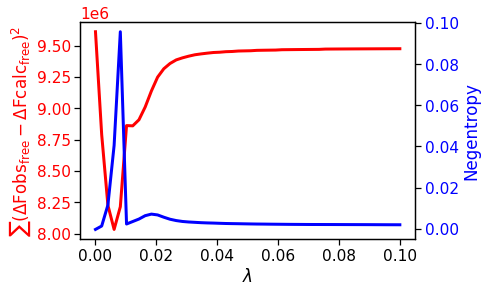

In [12]:
fig, ax1 = plt.subplots()

color = 'red'
ax1.set_xlabel(r'$\lambda$')
ax1.set_ylabel(r'$\sum (\Delta \mathrm{Fobs}_\mathrm{free} - \Delta \mathrm{Fcalc}_\mathrm{free})^2$', color=color)
ax1.plot(np.linspace(1e-8, 0.1, 50), errors, color=color, linewidth=3)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx() 

color = 'blue'
ax2.set_ylabel('Negentropy', color=color)  
ax2.plot(np.linspace(1e-8, 0.1, 50), entropies, color=color, linewidth=3)
ax2.tick_params(axis='y', labelcolor=color)

#fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()